<a href="https://colab.research.google.com/github/sgjheywa/StocksGAN/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
from tensorflow.keras import layers
import random
from keras.layers import Input, Dense, Reshape, Flatten, Dropout,TimeDistributed, LSTM, RNN, Dropout, RepeatVector
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.models import Sequential, Model
from keras.optimizers import RMSprop, Adam
import keras.backend as K
import keras
from collections import deque

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# stock data from https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs
# save to google drive if using in colab

FINDATA = []
filez = 0
n = 100  #chunk row size

path = r'/content/drive/My Drive/Stocks/'
all_files = glob.glob(path + "/*.txt")
for filename in all_files:
    try:
        df = pd.read_csv(filename)                
        df = df.iloc[0:, 4]
        list_df = [df[i:i+n] for i in range(0,df.shape[0],n)]
        
        for i in list_df:
            if len(i)==n:
                i = 2*((i-min(i))/(max(i)-min(i)))-1
                FINDATA.append(i)

        if(filez%100==0):
            print(filez, "NAME: ", filename)
            
        filez +=1
        
    except pd.io.common.EmptyDataError:
        print("file is empty")


0 NAME:  /content/drive/My Drive/Stocks/aapl.us.txt
file is empty
100 NAME:  /content/drive/My Drive/Stocks/adsw.us.txt
200 NAME:  /content/drive/My Drive/Stocks/alsk.us.txt
300 NAME:  /content/drive/My Drive/Stocks/agu.us.txt
file is empty
file is empty
400 NAME:  /content/drive/My Drive/Stocks/antm.us.txt
file is empty
500 NAME:  /content/drive/My Drive/Stocks/ascma.us.txt
600 NAME:  /content/drive/My Drive/Stocks/banc_d.us.txt
700 NAME:  /content/drive/My Drive/Stocks/bcd.us.txt
file is empty
800 NAME:  /content/drive/My Drive/Stocks/bfit.us.txt
file is empty
file is empty
900 NAME:  /content/drive/My Drive/Stocks/bned.us.txt
file is empty
1000 NAME:  /content/drive/My Drive/Stocks/catb.us.txt
1100 NAME:  /content/drive/My Drive/Stocks/ccf.us.txt
1200 NAME:  /content/drive/My Drive/Stocks/cfr.us.txt
1300 NAME:  /content/drive/My Drive/Stocks/chu.us.txt
1400 NAME:  /content/drive/My Drive/Stocks/cpac.us.txt
1500 NAME:  /content/drive/My Drive/Stocks/cris.us.txt
1600 NAME:  /content/d

In [0]:
print(len(FINDATA))

146215


In [0]:
class GAN():
    
    def __init__(self):

        self.optimizer = Adam(0.0001, 0.5)
        self.noise = 100
        self.shape = (100,)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=self.optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.make_generator_model()
        self.generator.compile(loss='binary_crossentropy',
            optimizer=self.optimizer,
            metrics=['accuracy'])

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.noise,))
        data = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(data)

        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=self.optimizer)     
        
    def make_generator_model(self):
        model = Sequential()
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.3))
        model.add(BatchNormalization())
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.3))
        model.add(BatchNormalization())
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.3))
        model.add(BatchNormalization())
        model.add(Dense(4096))
        model.add(Dense(np.prod(self.shape), activation='tanh'))
        model.compile(self.optimizer, loss='mse')

        return model

    def build_discriminator(self):
        model = Sequential()
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.3))
        model.add(Dropout(0.2))
        model.add(Dense(1024))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.3))
        model.add(Dropout(0.2))
        model.add(Dense(128))
        model.add(Dense(1, activation='sigmoid'))

        data = Input(shape=self.shape)
        validity = model(data)

        return Model(data, validity)
    
    def train(self, data, epochs, batch_size, sample_interval, fin=100):
            
        print_interval = 1000
        acc_test = deque(maxlen=fin)
        pltAcc = []
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        
        epoch_counter = 0
        while epoch_counter < epochs:

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            real_data = random.sample(data, batch_size)
            # real_data = np.expand_dims(real_data, axis=0)

            noise = np.random.normal(0, 1, (batch_size, 100))

            # Generate a batch of new images
            gen_data = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(np.array(real_data), valid)
            d_loss_fake = self.discriminator.train_on_batch(np.array(gen_data), fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)
            
            if epoch_counter % print_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch_counter, d_loss[0], 100*d_loss[1], g_loss))
            
            if epoch_counter % sample_interval == 0:
                self.sample_data(batch_size, epoch_counter)
                
            acc = 100*d_loss[1]
            pltAcc.append(acc)
            acc_test.append(acc)
            
            epoch_counter +=1
            
            if ((len(acc_test)==fin) and (np.mean(acc_test) == 50.0) and (np.std(acc_test) <= 1)) or epoch_counter== epochs:
                print("DONE", np.std(acc_test))
                self.sample_data(batch_size, epoch_counter)
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch_counter, d_loss[0], 100*d_loss[1], g_loss))
                print(d_loss_real , d_loss_fake)
                epoch_counter=epochs       
            
            
        plt.figure(figsize=(10, 5))
        plt.plot(pltAcc)
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.grid()
        plt.show()
        plt.close()
        
        gmodelname = "geno"
        dmodelname = "disc"
        cmodelname = "comb"
        self.generator.save("/content/drive/My Drive/" + gmodelname)
        self.discriminator.save("/content/drive/My Drive/" + dmodelname)
        self.combined.save("/content/drive/My Drive/" + cmodelname)

    def sample_data(self,batch_size, epoch):
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_data = self.generator.predict(noise)

        plt.figure(figsize=(10, 5))
        plt.plot(gen_data[0, :])
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.grid()
        plt.show()
        plt.close()



/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.694441, acc.: 40.62%] [G loss: 0.534621]


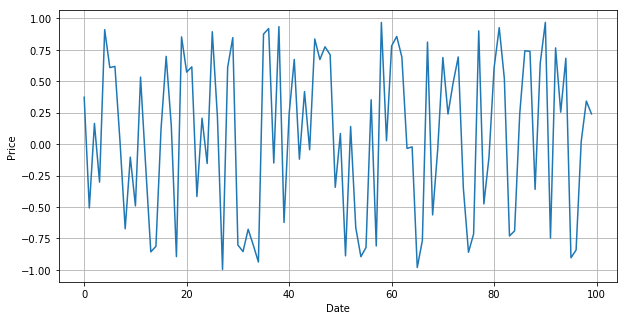

1000 [D loss: 0.017164, acc.: 98.44%] [G loss: 10.100182]


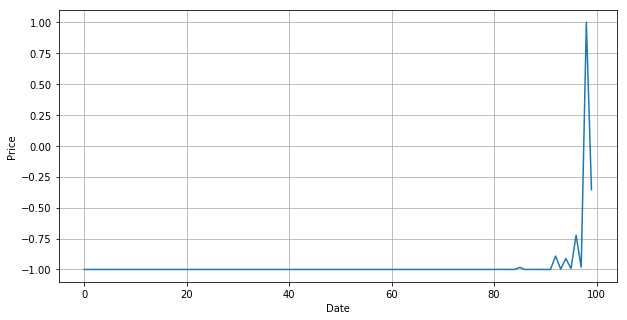

2000 [D loss: 0.084951, acc.: 95.31%] [G loss: 8.942373]


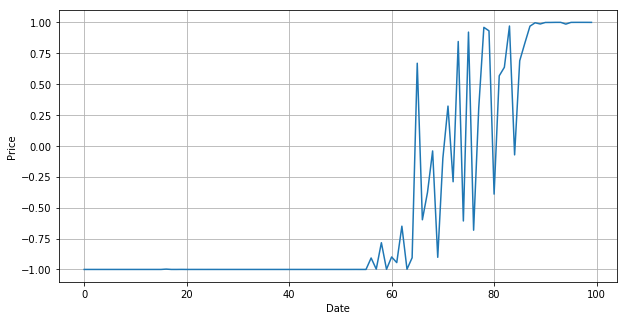

3000 [D loss: 0.628294, acc.: 57.81%] [G loss: 0.931360]


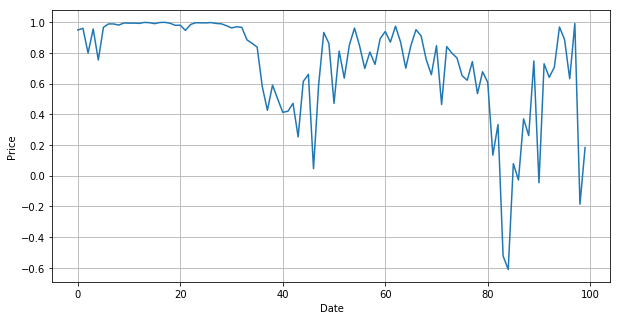

4000 [D loss: 0.647767, acc.: 60.94%] [G loss: 1.098892]


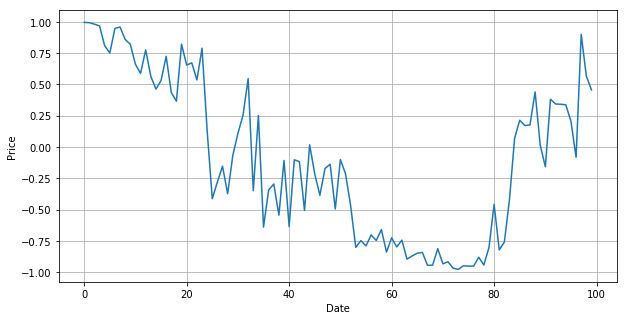

5000 [D loss: 0.662901, acc.: 53.12%] [G loss: 1.013999]


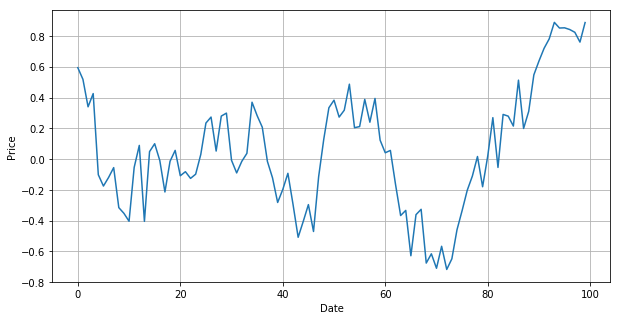

6000 [D loss: 0.617700, acc.: 62.50%] [G loss: 0.890087]


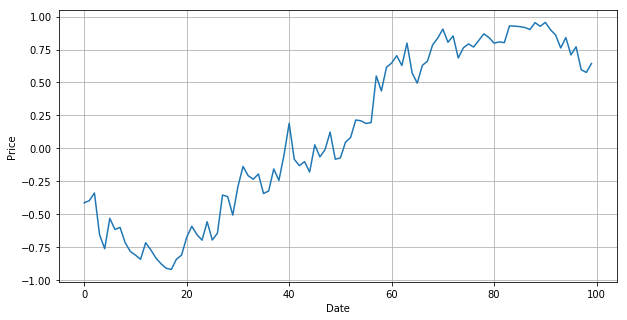

7000 [D loss: 0.676347, acc.: 56.25%] [G loss: 0.960056]


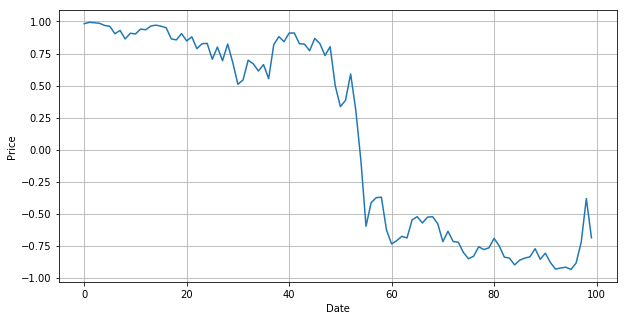

8000 [D loss: 0.683580, acc.: 57.81%] [G loss: 0.699623]


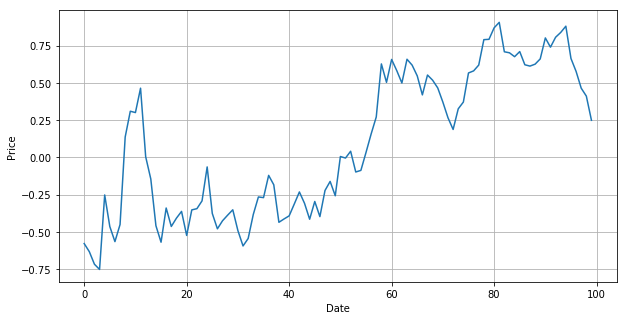

9000 [D loss: 0.649832, acc.: 65.62%] [G loss: 0.826065]


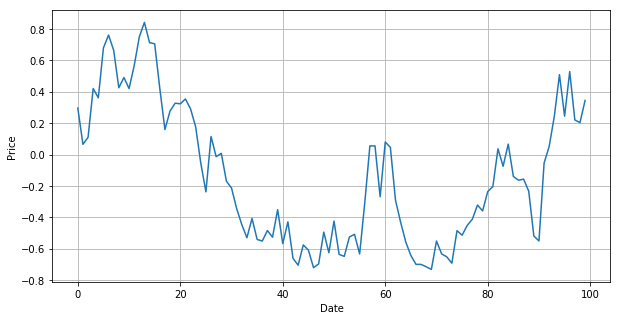

DONE 6.67776379463028


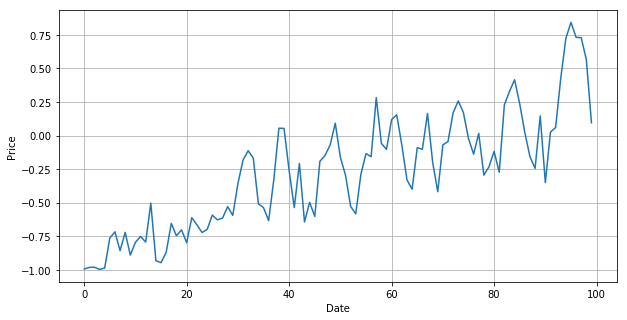

10000 [D loss: 0.687873, acc.: 53.12%] [G loss: 0.753778]
[0.6400517, 0.53125] [0.735695, 0.53125]


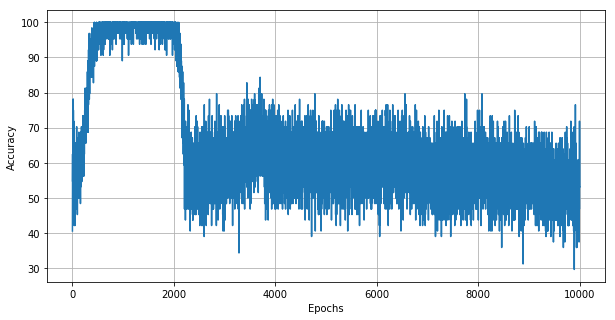

In [0]:
gan = GAN()

# generator = gan.make_generator_model()
# discriminator = gan.build_discriminator()

# noise = np.random.normal(0, 1, (50, 100))
# fake1 = generator.predict(noise)
# print(fake1.shape)

gan.train(FINDATA, epochs=10000, batch_size=32, sample_interval=1000)
# double these


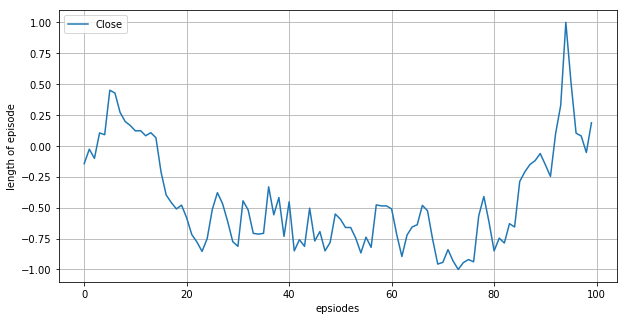

No handles with labels found to put in legend.


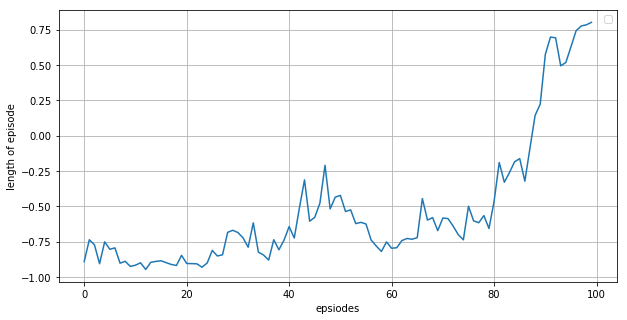

In [0]:
plt.figure(figsize=(10, 5))
plt.plot(FINDATA[11000])
plt.xlabel("epsiodes")
plt.ylabel("length of episode")
plt.legend()
plt.grid()
plt.show()

noise = np.random.normal(1, 1, (1, 100))
fake1 = gan.generator.predict(noise)

plt.figure(figsize=(10, 5))
plt.plot(fake1[0])
plt.xlabel("epsiodes")
plt.ylabel("length of episode")
plt.legend()
plt.grid()
plt.show()

In [0]:
plt.figure(figsize=(10, 5))
plt.plot(FINDATA[11000])
plt.xlabel("epsiodes")
plt.ylabel("length of episode")
plt.legend()
plt.grid()
plt.show()

noise = np.random.normal(1, 1, (1, 100))
fake2 = gan.generator.predict(noise)
i=fake2
i = 2*((i-min(i))/(max(i)-min(i)))-1

plt.figure(figsize=(10, 5))
plt.plot(i)
plt.xlabel("epsiodes")
plt.ylabel("length of episode")
plt.legend()
plt.grid()
plt.show()